In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, \
    recall_score
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Raluca\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
Data = pd.read_csv("Data_processed.csv")

In [3]:
Data[:5]

,Zone1Position,Zone2Position,Zone3Position,SKU,Zone1_Row_Num,Zone1_Col_Num,Zone2_Row_Num,Zone2_Col_num,Zone3_Row_Num,Zone3_Col_Num,...,Zone2_Humidity_Max,Zone2_Humidity_Range,Zone3_Humidity_Avg,Zone3_Humidity_Min,Zone3_Humidity_Max,Zone3_Humidity_Range,Block_Num,Block_Position,Block_Orientation,Result_Type
0,3.0,2.0,3.0,A001,1.0,3.0,1.0,2.0,1.0,3.0,...,61.80,10.0,39.19,33.19,45.19,12.0,1000.0,1.0,1,Defect_1
1,8.0,4.0,3.0,A001,2.0,4.0,2.0,2.0,1.0,3.0,...,58.12,16.0,48.50,40.50,56.50,16.0,1003.0,1.0,1,Defect_1
2,4.0,2.0,3.0,B003,1.0,4.0,1.0,2.0,1.0,3.0,...,50.97,10.0,52.20,46.20,58.20,12.0,1001.0,4.0,1,PASS
3,6.0,3.0,1.0,B003,2.0,2.0,2.0,1.0,1.0,1.0,...,59.13,4.0,39.29,31.29,47.29,16.0,1003.0,2.0,1,PASS
4,3.0,2.0,3.0,B003,1.0,3.0,1.0,2.0,1.0,3.0,...,65.80,18.0,45.37,42.37,48.37,6.0,1002.0,1.0,1,PASS


<b>Encoding categorical variables</b>

In [4]:
categorical_feature_mask = Data.dtypes==object
categorical_cols = Data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
Data[categorical_cols] = Data[categorical_cols].apply(lambda col: le.fit_transform(col))
target_names = list(le.classes_)
target_names

['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4', 'Defect_5', 'PASS']

<b>Important features indicated by Boruta and RPAT</b>

In [6]:
features_model1 = ['Zone1Position', 'Zone2Position', 'Zone3Position', 'SKU','Zone1_Row_Num', 'Zone1_Col_Num',
           'Zone2_Row_Num', 'Zone2_Col_num','Zone3_Row_Num', 'Zone3_Col_Num', 'Zone1_Left_Block_Bin',
           'Zone1_Right_Block_Bin', 'Zone1_Area', 'Zone3_Area', 'Zone1_In_Zone3_Out_Dur', 'Zone3_Temp_Min',
           'Zone3_Temp_Max', 'Zone3_Temp_Range', 'Zone3_Humidity_Avg', 'Zone3_Humidity_Min','Zone3_Humidity_Max',
           'Zone3_Humidity_Range', 'Block_Num','Block_Position']

<b>Split the data into training and test</b>

In [7]:
train, test = train_test_split(Data, test_size = 0.2)

x_train = train[features_model1]
y_train = train["Result_Type"]

x_test = test[features_model1]
y_test = test["Result_Type"]

<h3>1. Tuning the Decision Tree model by looking at different Max Depth, Accuracy and Mean Absolute Error</h3>

In [10]:
model_eval = []

for n_tree in range(15):
    rf = DecisionTreeClassifier(max_depth=n_tree+1)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred, normalize = True)
    error = abs(y_pred - y_test)
    model_eval.append([n_tree+1, accuracy, round(np.mean(error), 2)])

Model1_eval = pd.DataFrame(model_eval, columns=["Max depth", "Accuracy", "Mean Absolute Error (degrees)"])

print(Model1_eval)

Model1_eval.to_csv("Model1_eval.csv", index=False)

    Max depth  Accuracy  Mean Absolute Error (degrees)
0           1  0.721533                           0.87
1           2  0.791400                           0.61
2           3  0.796600                           0.61
3           4  0.824733                           0.46
4           5  0.845467                           0.37
5           6  0.870400                           0.29
6           7  0.880067                           0.26
7           8  0.881333                           0.26
8           9  0.879133                           0.26
9          10  0.877933                           0.26
10         11  0.875467                           0.27
11         12  0.869133                           0.28
12         13  0.863000                           0.30
13         14  0.855667                           0.32
14         15  0.847067                           0.34


<b>Best performing model has a Max Depth of 7, an accuracy of .88 and a Mean Absolute Error (how off is the average estimate) of 0.26 </b>

<h3>2. Tuning the model by assessing the features' importance</h3>

No handles with labels found to put in legend.


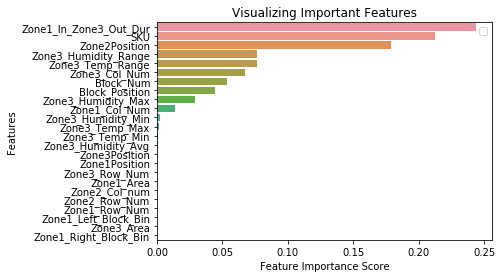

In [11]:
rf = DecisionTreeClassifier(max_depth=7)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

feature_imp = pd.Series(rf.feature_importances_,index=features_model1).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

<b>Out of the 25 features included in model 1, we keep only 10.</b>

<h3>3. Model 2 - with 10 features</h3>

In [12]:
feature_model2 = ['Zone1Position','SKU','Zone1_Col_Num','Zone3_Col_Num','Zone1_In_Zone3_Out_Dur','Zone3_Temp_Range',
                  'Zone3_Humidity_Max', 'Zone3_Humidity_Range', 'Block_Num', 'Block_Position']

x_train = train[feature_model2]
y_train = train["Result_Type"]
x_test = test[feature_model2]
y_test = test["Result_Type"]

<h3>4. Tuning model 2 by finding the Max depth with the higher Accuracy and lower Mean Absolute Error</h3>

In [13]:
model_eval = []

for n_tree in range(15):
    rf = DecisionTreeClassifier(max_depth=n_tree+1)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred, normalize = True)
    error = abs(y_pred - y_test)
    model_eval.append([n_tree+1, accuracy, round(np.mean(error), 2)])

Model2_eval = pd.DataFrame(model_eval, columns=["Max depth", "Accuracy", "Mean Absolute Error (degrees)"])

print(Model2_eval)

Model2_eval.to_csv("Model2_eval.csv", index=False)

    Max depth  Accuracy  Mean Absolute Error (degrees)
0           1  0.721533                           0.87
1           2  0.791400                           0.61
2           3  0.796600                           0.61
3           4  0.824733                           0.46
4           5  0.845400                           0.37
5           6  0.870533                           0.29
6           7  0.880800                           0.26
7           8  0.881800                           0.26
8           9  0.880600                           0.26
9          10  0.878333                           0.26
10         11  0.874200                           0.28
11         12  0.866933                           0.29
12         13  0.856400                           0.31
13         14  0.846200                           0.33
14         15  0.837333                           0.36


<b>Best performing model has a Max Depth of 7, an accuracy of .88 and a Mean Absolute Error (how off is the average estimate) of 0.26</b>

<h3> 5. Exporting the Classification report and Confusion matrix</h3>

In [14]:
rf = DecisionTreeClassifier(max_depth=7)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_table = pd.DataFrame(report).transpose()
report_table.to_csv("Classification_report.csv")

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_table = pd.DataFrame(conf_mat).transpose()
conf_mat_table.to_csv("Confusion_matrix.csv")

<h3> 6. Exporting the tree (still not working in Jupyter, check the Python file <i>export_tree.py</i>)</h3>

In [ ]:
dot_data = StringIO()

tree.export_graphviz(rf,
 out_file=dot_data,
 class_names= target_names, # the target names.
 feature_names= feature_model2, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_svg())

graph.write_svg("tree_exported.svg")

<h3> Currently, looking for ways to export the tree rules</h3>

In [20]:
from sklearn.tree.export import export_text
r = export_text(rf, feature_names=feature_model2, show_weights=True)

print(r)

|--- Zone1Position <= 2.50
|   |--- Zone1_In_Zone3_Out_Dur <= 99.99
|   |   |--- Zone3_Humidity_Max <= 39.87
|   |   |   |--- Block_Position <= 2.50
|   |   |   |   |--- Zone1_In_Zone3_Out_Dur <= 99.10
|   |   |   |   |   |--- Zone1Position <= 1.50
|   |   |   |   |   |   |--- Zone3_Humidity_Max <= 38.98
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00, 0.00, 0.00, 0.00, 13.00] class: 5
|   |   |   |   |   |   |--- Zone3_Humidity_Max >  38.98
|   |   |   |   |   |   |   |--- weights: [2.00, 0.00, 2.00, 2.00, 1.00, 11.00] class: 5
|   |   |   |   |   |--- Zone1Position >  1.50
|   |   |   |   |   |   |--- Block_Position <= 1.50
|   |   |   |   |   |   |   |--- weights: [0.00, 0.00, 0.00, 2.00, 1.00, 12.00] class: 5
|   |   |   |   |   |   |--- Block_Position >  1.50
|   |   |   |   |   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 25.00] class: 5
|   |   |   |   |--- Zone1_In_Zone3_Out_Dur >  99.10
|   |   |   |   |   |--- Zone3_Temp_Range <= 16.00
|   |   |   |   |   |   |-

In [ ]:
string_data = tree.export_graphviz(rf,
                                   out_file=None,
                                   class_names=target_names,  # the target names.
                                    feature_names= feature, # the feature names.
                                    filled=True, # Whether to fill in the boxes with colours.
                                    rounded=True, # Whether to round the corners of the boxes.
                                    special_characters=True
                                   )

print(string_data)